In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from torchtext.datasets import TranslationDataset



from torch.nn.utils import clip_grad_norm_
import io
from torchtext.data import Field
from torchtext.datasets import LanguageModelingDataset
from torchtext.data import Iterator
from collections import Counter
from google.colab import files


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder = 'drive/MyDrive/Colab_Notebooks/numbers__place_value'

# folder = 'drive/MyDrive/Colab_Notebooks/comparison__sort'

In [ ]:

# − TODO: Prepare ‘Field ‘ object for source and target:
 # ‘source_field ‘ and ‘target_field ‘
 # − TODO: Specify path to the data: ‘folder ‘

split_chars = lambda x: list(x) # keeps whitespaces

source_field = Field(tokenize=split_chars, init_token='<sos>', eos_token='<eos>', pad_token='<pad>')
target_field = Field(tokenize=split_chars, init_token='<sos>', eos_token='<eos>', pad_token='<pad>')

TRAIN_FILE_NAME = "train"
VALID_FILE_NAME = "interpolate"

INPUTS_FILE_ENDING = ".x"
TARGETS_FILE_ENDING = ".y"

train_dataset , valid_dataset , _ = TranslationDataset.splits(
path=folder ,
root=folder ,
exts=(INPUTS_FILE_ENDING , TARGETS_FILE_ENDING),
fields=(source_field , target_field),
train=TRAIN_FILE_NAME ,
validation=VALID_FILE_NAME,
test=VALID_FILE_NAME)

source_field.build_vocab(train_dataset)
target_field.build_vocab(train_dataset)

In [ ]:

# Hyperparameters

train_bs = 64 # TODO: batch size, 64 is arbitrary
valid_bs = 64 # TODO: batch size, 64 is arbitrary
src_vocab = len(source_field.vocab)
tgt_vocab = len(target_field.vocab)
d_hidden = 256
nhead = 8
encoder_layers = 3
decoder_layers = 2
d_FF = 1024
max_seq_length = 2

In [ ]:
with open(folder +'/train.xy', 'r') as f:
    train_xy = f.read()

with open(folder +'/interpolate.xy', 'r') as f:
    interpolate_xy = f.read()

with open(folder +'/train.x', 'r') as f:
    train_x = f.read()

with open(folder +'/interpolate.x', 'r') as f:
    interpolate_x = f.read()

with open(folder +'/train.y', 'r') as f:
    train_y = f.read()

with open(folder +'/interpolate.y', 'r') as f:
    interpolate_y = f.read()

print("# of training vocab : {}".format(len(source_field.vocab)))
print("# of validation vocab : {}".format(len(target_field.vocab)))
print("# of training chars : {}".format(len(train_xy)))
print("# of validation chars : {}".format(len(interpolate_xy)))
print("# of training sentences : {}".format(len(train_xy.split('\n'))-1))
print("# of validation sentences : {}".format(len(interpolate_xy.split('\n'))-1))
print("Training average question length : {}".format(round(int(len(train_x)) / int(len(train_x.split('\n'))-1))))
print("Validation average question length : {}".format(round(int(len(interpolate_x)) / int(len(interpolate_x.split('\n'))-1))))
print("Training average answer length : {}".format(round(int(len(train_y)) / int(len(train_y.split('\n'))-1))))
print("Validation average answer length : {}".format(round(int(len(interpolate_y)) / int(len(interpolate_y.split('\n'))-1))))


print(target_field.vocab.stoi)

FileNotFoundError: ignored

In [ ]:
train_iterator = Iterator(
dataset=train_dataset ,
batch_size= train_bs ,
train=True,
repeat=False,
shuffle=True,
 device=device)


valid_iterator = Iterator(
dataset=valid_dataset ,
batch_size= valid_bs ,
train=False,
repeat=False,
shuffle=True,
 device=device)

train_iterator.create_batches
valid_iterator.create_batches

<bound method Iterator.create_batches of <torchtext.data.iterator.Iterator object at 0x7f07ff428128>>

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape (max_len , 1, dim)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe) # Will not be trained.


    def forward(self, x):
        # shape of x: (len, B, dim)
        assert x.size(0) < self.max_len , (f"Too long sequence: increase ‘max_len‘") # shape of x (len, B, dim)

        x = x + self.pe[:x.size(0), :]
        return x

In [ ]:


class MathTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length):
        super().__init__()

        self.d_model = d_model
        self.pos_enc = PositionalEncoding(d_model)
        self.input_embed = nn.Embedding(vocab_size_src, d_model)
        self.output_embed = nn.Embedding(vocab_size_tgt, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, 0)
        self.fc = nn.Linear(d_model, vocab_size_tgt)


    def generate_square_subsequent_mask(self, n: int):

        mask = (torch.triu(torch.ones(n, n)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def generate_padding_mask(self, pad):

        mask = (pad != target_field.vocab.stoi['<pad>'])
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def forward(self, src, tgt):

        output = self.transformer(self.pos_enc(self.input_embed(src).transpose(0,1)).to(device),
                                  self.pos_enc(self.output_embed(tgt).transpose(0,1)).to(device),
                                  tgt_mask=self.generate_square_subsequent_mask(tgt.shape[1]).to(device),
                                  src_key_padding_mask=self.generate_padding_mask(src).to(device) ,
                                  tgt_key_padding_mask=self.generate_padding_mask(tgt).to(device),
                                  memory_key_padding_mask=self.generate_padding_mask(src).to(device))
        return self.fc(output.transpose(1,0))



In [ ]:
def greedy(model, src, bs, max_seq_length):

    tgt = torch.tensor([target_field.vocab.stoi['<sos>']]*bs).long().view(bs,-1).to(device)
    enc_src = model.pos_enc(model.input_embed(src).transpose(1,0)).to(device)
    src_key_padding_mask = model.generate_padding_mask(src).to(device)
    memory = model.transformer.encoder(src = enc_src, src_key_padding_mask=src_key_padding_mask).to(device)
    counter = 0

    while True:
        counter +=1
        tgt_enc = model.pos_enc(model.output_embed(tgt).transpose(1,0)).to(device)
        tgt_key_padding_mask = model.generate_padding_mask(tgt).to(device)
        tgt_mask = model.generate_square_subsequent_mask(tgt.shape[1]).to(device)

        decoder_output = model.transformer.decoder(tgt_enc,memory,tgt_mask=tgt_mask,
                                                   tgt_key_padding_mask=tgt_key_padding_mask,
                                                   memory_key_padding_mask=src_key_padding_mask.to(device))

        fc_output = model.fc(decoder_output.transpose(1,0)).to(device)
        prediction = torch.argmax(fc_output, dim=2)[:,-1]
        tgt = torch.cat([tgt, prediction.view(bs,-1)],dim=1)

        if prediction == target_field.vocab.stoi['<eos>'] or counter == max_seq_length:
            return torch.argmax(fc_output, dim=2)

In [ ]:
def train(train_iter, val_iter, model, optim):

    loss_func = nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    valid_loss_mean = []
    training_accuracy = []
    valid_accuracy = []
    train_loss_mean = []

    counter = 0
    train_loss = 0
    valid_loss = 0

    for i, batch in enumerate(train_iter):

        src = batch.src.to(device)
        src = src.transpose(1,0)

        trg = batch.trg.to(device)
        trg = trg.transpose(1,0)
        trg_input = trg[:, :-1]
        target_contigous = trg[:, 1:].contiguous().view(-1)


        out = model(src,trg_input)
        out_for_pred = out

        out = out.contiguous().view(-1, out.size(-1))
        loss = loss_func(out, target_contigous)
        loss.backward()
        train_losses.append(loss.item())

        if i %10 == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)
            optim.step()
            optim.zero_grad()

        if i % 500 == 0:
            training_accuracy.append(100 * (torch.sum((torch.argmax(out_for_pred, dim=2) == trg[:, 1:]).all(1))/trg[:, 1:].size(0)))

            model.eval()
            print("Step #{}, Training loss: {}, Training accuracy: {}%".format(counter,np.mean(train_losses),
            100 * (torch.sum((torch.argmax(out_for_pred, dim=2) == trg[:, 1:]).all(1))/trg[:, 1:].size(0))))

            counter += 500

            train_losses.append(train_loss / len(train_iter))

            questions = ["What is the hundreds digit of 74623912?",
                        "What is the hundred thousands digit of 17858349?",
                        "What is the hundred thousands digit of 99883826?"]


            # questions = ["Put -1, -10, 5, -378, -2, -6, -5 in descending order.",
            #              "Sort 371, 5, 10387 in increasing order.",
            #              "Sort -1, -19, -205, 18, -4 in descending order."]

            train_loss_mean.append(np.mean(train_losses))

            for question in questions:
                print(question)

                tokenized = source_field.process([question]).to(device)
                greedy_res = greedy(model=model, src=tokenized.view(1,-1), bs=1, max_seq_length=max_seq_length)
                print([target_field.vocab.itos[j] for j in greedy_res[0]])


            model.eval()
            with torch.no_grad():
                for i, batch in enumerate(valid_iterator):

                    src = batch.src.to(device)
                    src = src.transpose(1,0)

                    trg = batch.trg.to(device)
                    trg = trg.transpose(1,0)
                    trg_input = trg[:, :-1]
                    target_contigous = trg[:, 1:].contiguous().view(-1)


                    out = model(src,trg_input)
                    out_for_pred = out

                    out = out.contiguous().view(-1, out.size(-1))
                    loss = loss_func(out, target_contigous)
                    valid_losses.append(loss.item())

            valid_accuracy.append(100 * (torch.sum((torch.argmax(out_for_pred, dim=2) == trg[:, 1:]).all(1))/trg[:, 1:].size(0)))
            valid_loss_mean.append(np.mean(valid_losses))


    fig, ax1 = plt.subplots()
    fig, ax2 = plt.subplots()

    ax1.plot(train_loss_mean)
    ax1.plot(valid_loss_mean)
    ax1.legend(["Training Loss", "Validation loss"])
    ax1.set_xlabel("Steps", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)

    plt.show

    ax2.plot(training_accuracy)
    ax2.plot(valid_accuracy)
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
    ax2.set_xlabel("Steps", fontsize=16)
    ax2.set_ylabel("Accuracy", fontsize=16)

    plt.show

    return "Finished!"




Step #0, Training loss: 2.96854305267334, Training accuracy: 0.0%
Put -1, -10, 5, -378, -2, -6, -5 in descending order.
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Sort 371, 5, 10387 in increasing order.
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

'Training Finished!'

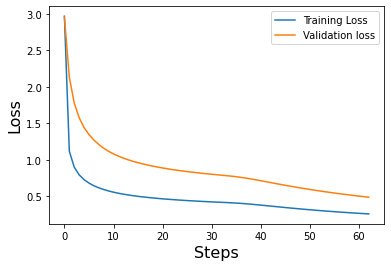

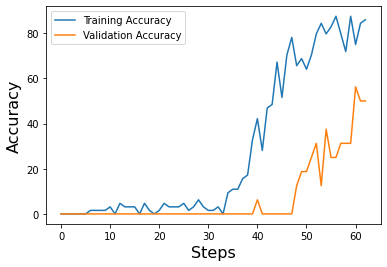

In [ ]:
model = MathTransformer(src_vocab,tgt_vocab,d_hidden,nhead,encoder_layers,decoder_layers,d_FF,max_seq_length).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

train(train_iterator, valid_iterator, model, optim)